In [1]:
import cv2
import dlib
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from util import *

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

In [2]:
face_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor("./dlib/shape_predictor_68_face_landmarks.dat")

In [3]:
with open('./dataset/ck.plus.pickle','rb') as f:
    ck_data, ck_label = pickle.load(f)

In [4]:
%%time
face_landmarks_train = [] 
face_label_train = []
face_landmarks_test = []
face_label_test = []
face_landmarks_coords_x = []
face_landmarks_coords_y = []

def process_face(face, k, d):
    global face_landmarks_coords_x
    global face_landmarks_coords_y
    shape = landmark_predictor(face, d)
        
    xlist = [float(shape.part(i).x) for i in range(68)]
    ylist = [float(shape.part(i).y) for i in range(68)]
    xmean = np.mean(xlist)
    ymean = np.mean(ylist)
    xcentral = xlist - xmean
    ycentral = ylist - ymean
    
    face_landmarks_coords_x.append(xlist)
    face_landmarks_coords_y.append(ylist)

    landmarks_vectorised = []
    for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
        landmarks_vectorised.append(w)
        landmarks_vectorised.append(z)

        meannp = np.asarray((ymean,xmean))
        coornp = np.asarray((z,w))
        dist = np.linalg.norm(coornp-meannp)

        landmarks_vectorised.append(dist)
        landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))

    return landmarks_vectorised

ck_data_train, ck_data_test, ck_label_train, ck_label_test = train_test_split(ck_data, np.asarray(ck_label), test_size=0.25, random_state=42)
counter = 1

for face, label in zip(ck_data_train, ck_label_train):
    face = np.array(face)
    faces = face_detector(face.reshape(128,128), 1)
    for k,d in enumerate(faces):
        landmarks_vectorised = process_face(face.reshape(128,128), k, d)
        
        face_landmarks_train.append(landmarks_vectorised)
        face_label_train.append(label)
    
for face, label in zip(ck_data_test, ck_label_test):
    face = np.array(face)
    faces = face_detector(face.reshape(128,128), 1)
    
    for k,d in enumerate(faces):
        landmarks_vectorised = process_face(face.reshape(128,128), k, d)
        
        face_landmarks_test.append(landmarks_vectorised)
        face_label_test.append(label)
        

CPU times: user 34.4 s, sys: 32 ms, total: 34.5 s
Wall time: 34.5 s


Text(0.5,1,'Face Landmark plot on Image')

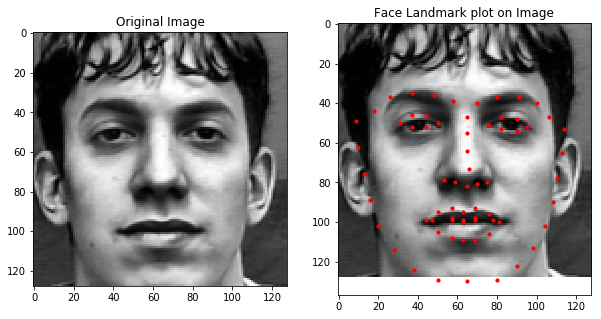

In [5]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(ck_data[1].reshape(128,128), cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(ck_data[1].reshape(128,128), cmap='gray')
plt.scatter(face_landmarks_coords_x[1], face_landmarks_coords_y[1], s=10, c='red')
plt.title('Face Landmark plot on Image')

In [6]:
target_classes = get_face_label()
target_classes

['😐', '😠', '😏', '😷', '😨', '😀', '😢', '😱']

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
              precision    recall  f1-score   support

           😐       0.97      0.98      0.97       323
           😠       1.00      0.98      0.99        90
           😏       0.88      0.91      0.89        23
           😷       0.98      0.95      0.96        86
           😨       1.00      0.98      0.99        42
           😀       0.99      1.00      1.00       129
           😢       0.96      0.98      0.97        44
           😱       0.99      0.98      0.98       121

   micro avg       0.98      0.98      0.98       858
   macro avg       0.97      0.97      0.97       858
weighted avg       0.98      0.98      0.98       858

Accuracy:  0.9766899766899767
Normalized confusion matrix
CPU times: user 5min 24s, sys: 2.37 s, total: 5min 27s
Wall ti

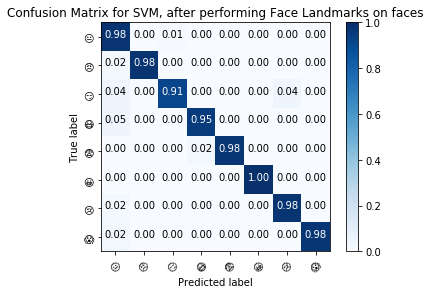

In [7]:
%%time

param_grid_svm =  {'kernel' : ['rbf', 'linear'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'decision_function_shape': ['ovo', 'ovr']}

clf_svm = GridSearchCV(SVC(class_weight='balanced', random_state=42), param_grid_svm, iid=True, n_jobs=-1)

clf_svm = clf_svm.fit(face_landmarks_train, face_label_train)
ck_label_predict_svm = clf_svm.predict(face_landmarks_test)

print(clf_svm.best_estimator_)

print(classification_report(face_label_test, ck_label_predict_svm, target_names=target_classes))
print('Accuracy: ' , accuracy_score(face_label_test, ck_label_predict_svm))

cm = confusion_matrix(face_label_test, ck_label_predict_svm, labels=range(8))
plot_confusion_matrix(cm, classes=target_classes, title='Confusion Matrix for SVM, after performing Face Landmarks on faces', normalize=True)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='distance')
              precision    recall  f1-score   support

           😐       0.94      0.96      0.95       323
           😠       0.98      0.97      0.97        90
           😏       0.79      0.83      0.81        23
           😷       0.94      0.93      0.94        86
           😨       0.97      0.88      0.93        42
           😀       0.99      1.00      1.00       129
           😢       0.89      0.91      0.90        44
           😱       0.99      0.94      0.97       121

   micro avg       0.95      0.95      0.95       858
   macro avg       0.94      0.93      0.93       858
weighted avg       0.95      0.95      0.95       858

Accuracy:  0.9522144522144522
Normalized confusion matrix
CPU times: user 2min, sys: 1.12 s, total: 2min 1s
Wall time: 2min 3s


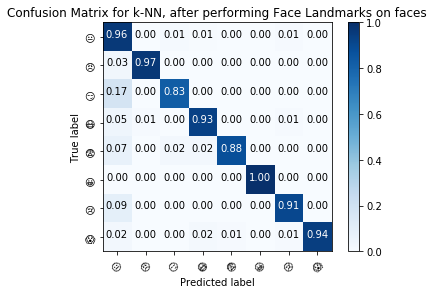

In [8]:
%%time

param_grid_knn =  {'n_neighbors': [3,5,7], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}

clf_knn = GridSearchCV(KNeighborsClassifier(),  param_grid_knn, iid=True, n_jobs=-1)
clf_knn = clf_knn.fit(face_landmarks_train, face_label_train)
ck_label_predict_knn = clf_knn.predict(face_landmarks_test)

print(clf_knn.best_estimator_)

print(classification_report(face_label_test, ck_label_predict_knn, target_names=target_classes))
print('Accuracy: ' , accuracy_score(face_label_test, ck_label_predict_knn))

cm = confusion_matrix(face_label_test, ck_label_predict_knn, labels=range(8))
plot_confusion_matrix(cm, classes=target_classes, title='Confusion Matrix for k-NN, after performing Face Landmarks on faces', normalize=True)

              precision    recall  f1-score   support

           😐       0.66      0.20      0.31       323
           😠       0.00      0.00      0.00        90
           😏       0.25      0.04      0.07        23
           😷       0.91      0.37      0.53        86
           😨       0.09      0.83      0.17        42
           😀       0.98      0.50      0.67       129
           😢       0.15      0.32      0.21        44
           😱       0.64      0.97      0.77       121

   micro avg       0.38      0.38      0.38       858
   macro avg       0.46      0.40      0.34       858
weighted avg       0.60      0.38      0.40       858

Accuracy:  0.38344988344988346
Normalized confusion matrix
CPU times: user 1.77 s, sys: 12 ms, total: 1.78 s
Wall time: 908 ms


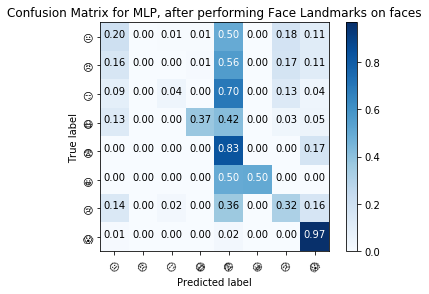

In [9]:
%%time

clf_mlp = MLPClassifier(random_state=42)
clf_mlp = clf_mlp.fit(face_landmarks_train, face_label_train)
ck_label_predict_mlp = clf_mlp.predict(face_landmarks_test)

print(classification_report(face_label_test, ck_label_predict_mlp, target_names=target_classes))
print('Accuracy: ' , accuracy_score(face_label_test, ck_label_predict_mlp))

cm = confusion_matrix(face_label_test, ck_label_predict_mlp, labels=range(8))
plot_confusion_matrix(cm, classes=target_classes, title='Confusion Matrix for MLP, after performing Face Landmarks on faces', normalize=True)